In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'apple-quality:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4291772%2F7384155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T181535Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0dbed1770836d1808f98bc96e042fe043e5a9c83644cbddc2eef8eaebbf0fcc241198d252dea0f63b1d4e6594bf6a29c82c5890f10416ddd36aed18c0528ff204e5ffb0f494af4406c90fb4abdda438336da00cc7109b055797b9ced55cbb1801cf86a268ff77f2ffdcf5f8717fdd7fa160940472c7b2bd0a927467216667f555bdec83b3359b45749b2decdb3aac487d2e1a0ca3a397092abf926b072e50c34e01aabce32db43ad737e76356333b77bd3cf2b2b4647156a27dfad75a157f434d5716f6f81a00115fa8aa335a95f30e3ea16fffd861aec9281b52e513efe2de2054d220aa1c10dc0bf5f5014d3539529c7538bce3c7aa5faf011bedf8fce9d24'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 174361 bytes downloaded
Downloaded and uncompressed: apple-quality
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/apple-quality/apple_quality.csv


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor


import seaborn as sns
import matplotlib.pyplot as plt
import inspect

In [ ]:

df = pd.read_csv('apple_quality.csv')

In [ ]:
df.columns

Index(['A_id', 'Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness',
       'Ripeness', 'Acidity', 'Quality'],
      dtype='object')

In [ ]:


df.describe()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277
std,1154.844867,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427
min,0.000000,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212
max,3999.000000,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837


In [ ]:


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


In [ ]:
df.dropna(inplace = True)

In [ ]:
df.drop('A_id',inplace = True , axis = 1)

In [ ]:
df

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good
...,...,...,...,...,...,...,...,...
3995,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784369,bad
3996,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235285,good
3997,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611391,bad
3998,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229719806,good


In [ ]:
Acidity = df['Acidity']
Acidity = Acidity.astype(float)



In [ ]:
X,Y = df.drop('Quality' ,axis =1),df['Quality']

In [ ]:
 # converting time series value to array

In [ ]:
mapping ={'good':1
          , 'bad':0}

y_map = np.array(Y.map(mapping))
y_map


array([1, 1, 0, ..., 0, 1, 1])

In [ ]:
# scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X) # it will be an array
X_new = pd.DataFrame(X_scaled, columns = X.columns)
X_new

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
0,0.234669,0.358370,0.922484,0.368781,0.585819,0.472770,0.452225
1,0.439331,0.333107,0.795706,0.558928,0.511408,0.513807,0.436185
2,0.505948,0.448092,0.388567,0.417732,0.660388,0.444693,0.668192
3,0.479014,0.376971,0.619422,0.435629,0.720370,0.187052,0.541180
4,0.628107,0.452317,0.490589,0.402347,0.674814,0.348084,0.521150
...,...,...,...,...,...,...,...
3995,0.531867,0.470029,0.239644,0.477379,0.574794,0.618866,0.495885
3996,0.505867,0.703146,0.504203,0.395971,0.449218,0.364566,0.614957
3997,0.333173,0.387278,0.335661,0.490846,0.612443,0.811182,0.393744
3998,0.231869,0.415014,0.697913,0.428137,0.609571,0.463966,0.331650


<Figure size 1000x1000 with 0 Axes>

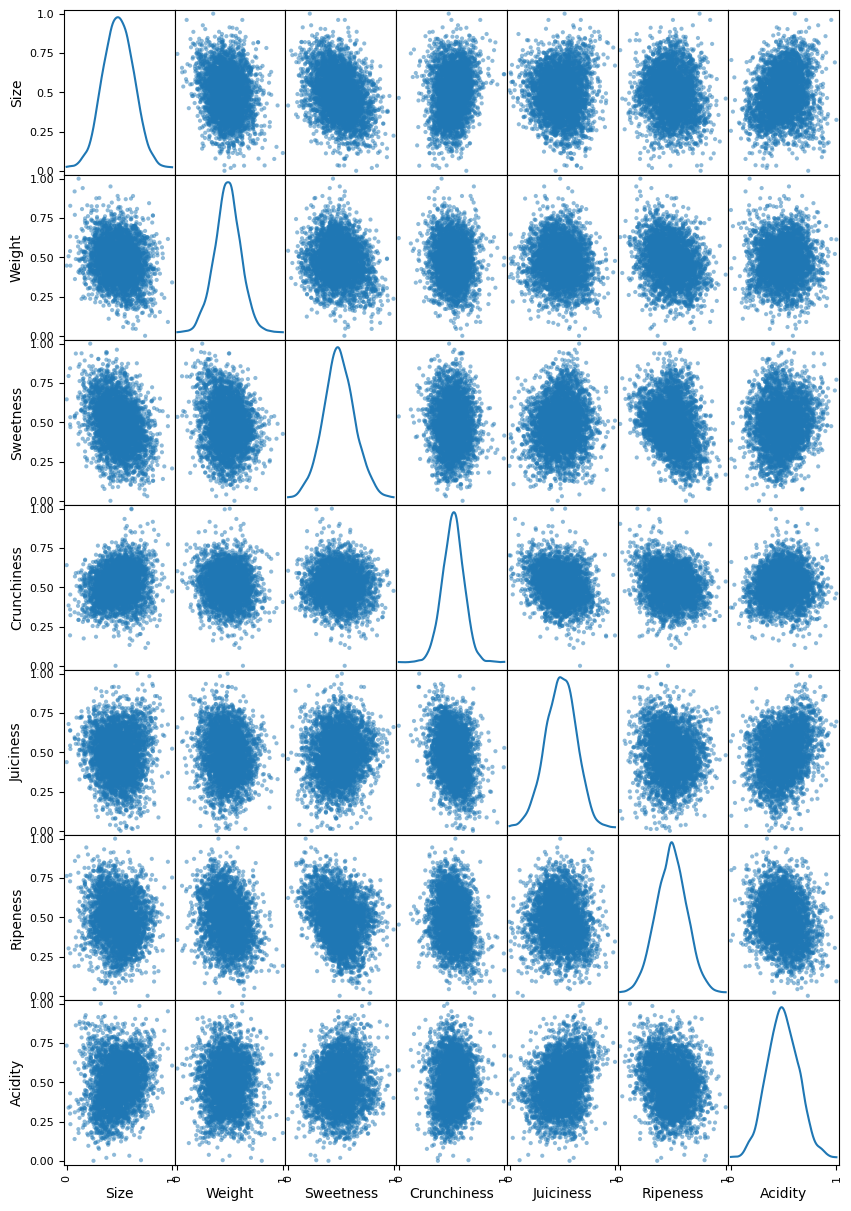

In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
plt.figure(figsize=(10,10))
scatter_matrix(X_new,figsize=(10,15),hist_kwds={'bins': 20},alpha =0.5,diagonal='kde');

Text(0.5, 1.0, 'Heat_Map_Of_Correlation_Matrix')

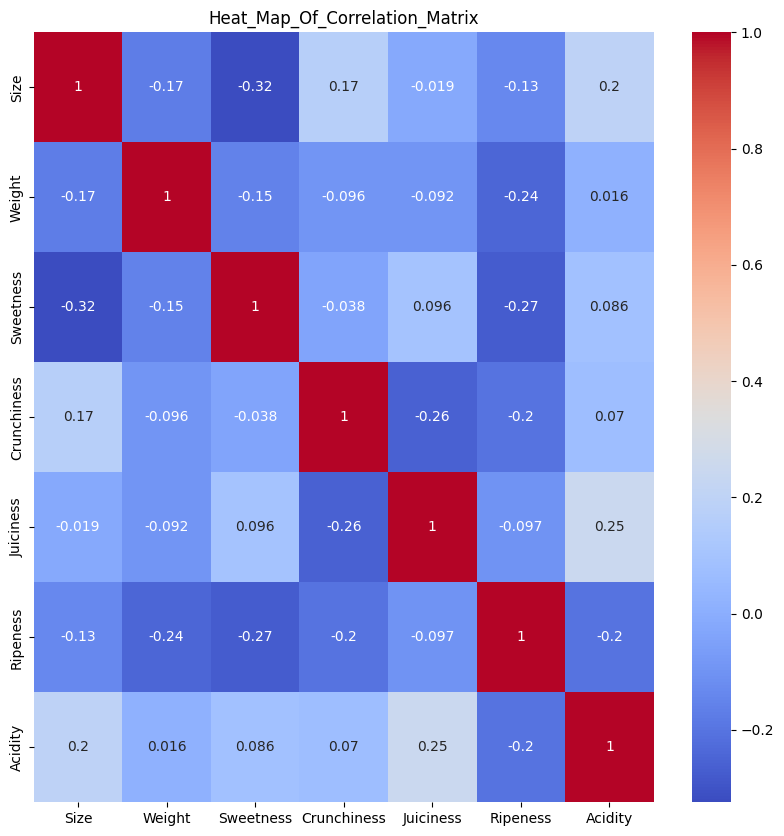

In [ ]:
corr_matrix  = X_new.corr()
plt.figure(figsize=(10,10))
# plt.imshow(corr_matrix, cmap ='coolwarm',interpolation='nearest') ----- i donot like this plot let's try with sns
sns.heatmap(corr_matrix , annot=True , cmap= 'coolwarm')
plt.title("Heat_Map_Of_Correlation_Matrix")

In [ ]:

x_train,x_test,y_train, y_test = train_test_split(X_new,y_map,test_size =0.3)
x_test,x_dev,y_test,y_dev= train_test_split(x_test,y_test,test_size = 0.3)
x_train.shape , y_train.shape , x_test.shape , y_test.shape , x_dev.shape , y_dev.shape

((2800, 7), (2800,), (840, 7), (840,), (360, 7), (360,))

In [ ]:

def model_check_k_fold_training(x_train,y_train,Model):

    print(f" shapes are x_train -{x_train.shape} , y_train-   {y_train.shape}, x_test - {x_test.shape} ,y_test-  {y_test.shape} , x_dev -  {x_dev.shape}   , y_dev -{y_dev.shape}")

    model = Model

    scores = cross_val_score(Model,x_train,y_train,scoring = 'neg_mean_squared_error',cv=10)
    rmse_score = np.sqrt(-scores)

    print("scores : ",rmse_score)
    print("mean : ",rmse_score.mean())
    print("standard_deviation : ",rmse_score.std())

In [ ]:
def plot_learning_curves(model,x_train,x_dev,y_train,y_dev):
    train_errors,dev_errors = [],[]
    for m in range(1,len(x_train)):
        model.fit(x_train[:m],y_train[:m])
        y_train_predict = model.predict(x_train[:m])
        y_dev_predict = model.predict(x_dev)
        train_errors.append(mean_squared_error(y_train[:m],y_train_predict))
        dev_errors.append(mean_squared_error(y_dev,y_dev_predict))
    plt.plot(np.sqrt(train_errors),'r-+',linewidth = 2,label ='train')
    plt.plot(np.sqrt(dev_errors),'b-',linewidth = 3,label ='dev')
    plt.legend()

In [ ]:
def modified_less_iteration_plot_learning_curves(model,x_train,x_dev,y_train,y_dev):
    train_errors,dev_errors = [],[]
    for m in range(1,int(len(x_train)/8)):
        model.fit(x_train[:m],y_train[:m])
        y_train_predict = model.predict(x_train[:m])
        y_dev_predict = model.predict(x_dev)
        train_errors.append(mean_squared_error(y_train[:m],y_train_predict))
        dev_errors.append(mean_squared_error(y_dev,y_dev_predict))
    plt.plot(np.sqrt(train_errors),'r-+',linewidth = 2,label ='train')
    plt.plot(np.sqrt(dev_errors),'b-',linewidth = 3,label ='dev')
    plt.legend()

In [ ]:

def model_check_test(x_test,y_test,Model):

    model = Model
    model.fit(x_test,y_test)
    prediction = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(prediction,y_test))
    print(f"rmse:{rmse}")

In [ ]:
model_check_k_fold_training(x_train,y_train,RandomForestRegressor())
print()
print()
model_check_k_fold_training(x_train,y_train,LinearRegression())
print()
print()
model_check_k_fold_training(x_train,y_train,DecisionTreeRegressor())
print()
print()
model_check_k_fold_training(x_train,y_train,SVR())


 shapes are x_train -(2800, 7) , y_train-   (2800,), x_test - (840, 7) ,y_test-  (840,) , x_dev -  (360, 7)   , y_dev -(360,)
scores :  [0.26320484 0.27856007 0.31956611 0.30103868 0.28661198 0.3206695
 0.27253833 0.32684968 0.32031904 0.29732978]
mean :  0.2986688017333382
standard_deviation :  0.021636206751658386


 shapes are x_train -(2800, 7) , y_train-   (2800,), x_test - (840, 7) ,y_test-  (840,) , x_dev -  (360, 7)   , y_dev -(360,)
scores :  [0.40939706 0.41166849 0.43457755 0.41366694 0.40202134 0.43518849
 0.4167163  0.43831258 0.41588831 0.42243031]
mean :  0.41998673733790615
standard_deviation :  0.011650388310477967


 shapes are x_train -(2800, 7) , y_train-   (2800,), x_test - (840, 7) ,y_test-  (840,) , x_dev -  (360, 7)   , y_dev -(360,)
scores :  [0.40532174 0.41833001 0.43506978 0.46675169 0.43915503 0.45118891
 0.40089186 0.48916839 0.41833001 0.42257713]
mean :  0.4346784561315936
standard_deviation :  0.02641016694213426


 shapes are x_train -(2800, 7) , y_tra

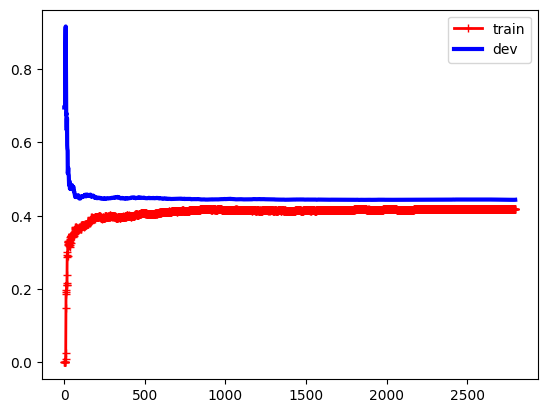

In [ ]:
plot_learning_curves(LinearRegression(),x_train,x_dev,y_train,y_dev)

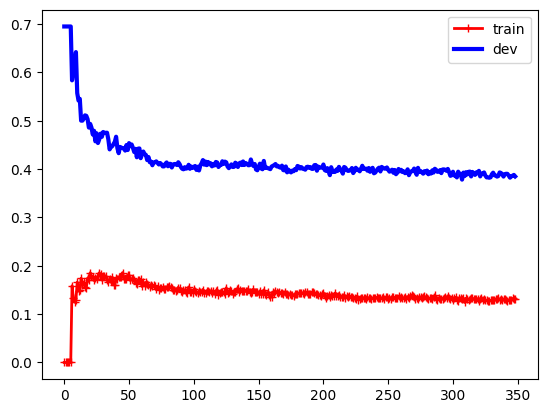

In [ ]:
modified_less_iteration_plot_learning_curves(RandomForestRegressor(),x_train,x_dev,y_train,y_dev)

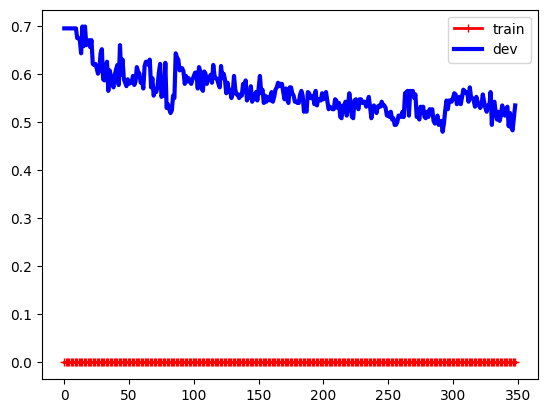

In [ ]:
modified_less_iteration_plot_learning_curves(DecisionTreeRegressor(),x_train,x_dev,y_train,y_dev)

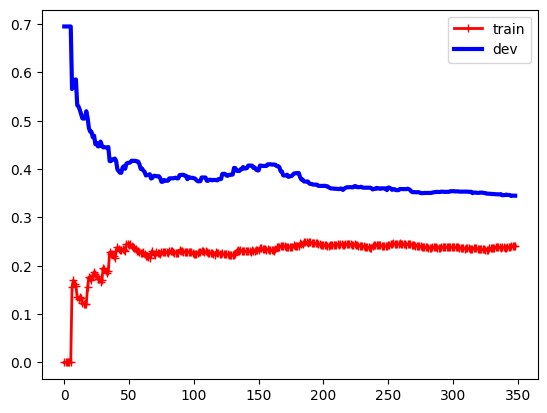

In [ ]:
modified_less_iteration_plot_learning_curves(SVR(),x_train,x_dev,y_train,y_dev)

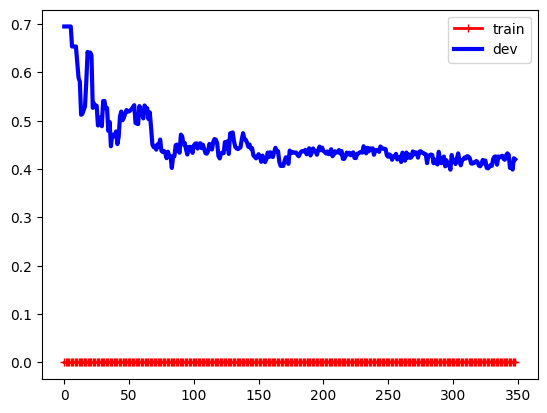

In [ ]:
from xgboost import XGBRegressor
modified_less_iteration_plot_learning_curves(XGBRegressor(),x_train,x_dev,y_train,y_dev)

In [ ]:

model_check_test(x_test,y_test,LinearRegression())
model_check_test(x_test,y_test,XGBRegressor())
model_check_test(x_test,y_test,RandomForestRegressor())
model_check_test(x_test,y_test,SVR())
model_check_test(x_test,y_test,DecisionTreeRegressor())

rmse:0.4050946294153295
rmse:0.009413558611828847
rmse:0.12324530320423883
rmse:0.26185076376714717
rmse:0.0
